# Draft

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from package.dl_model import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Conv2D Auto-Encoder

In [3]:
eeg = []
lab = pd.read_csv('./dataset/label.csv', sep=';', index_col=0)
msk = np.load('./models/row_mask.npy')[:len(lab)]
with h5py.File('./dataset/train.h5', 'r') as dtb:
    for key in ['eeg_{}'.format(dim) for dim in range(1, 5)]:
        tmp = dtb[key].value[msk][:100]
        tmp = np.asarray([interpolate(ele, size=750) for ele in tmp])
        eeg.append(tmp.reshape(tmp.shape[0], 1, tmp.shape[1]))
eeg = np.concatenate(tuple(eeg), axis=1)
lab = lab[msk]

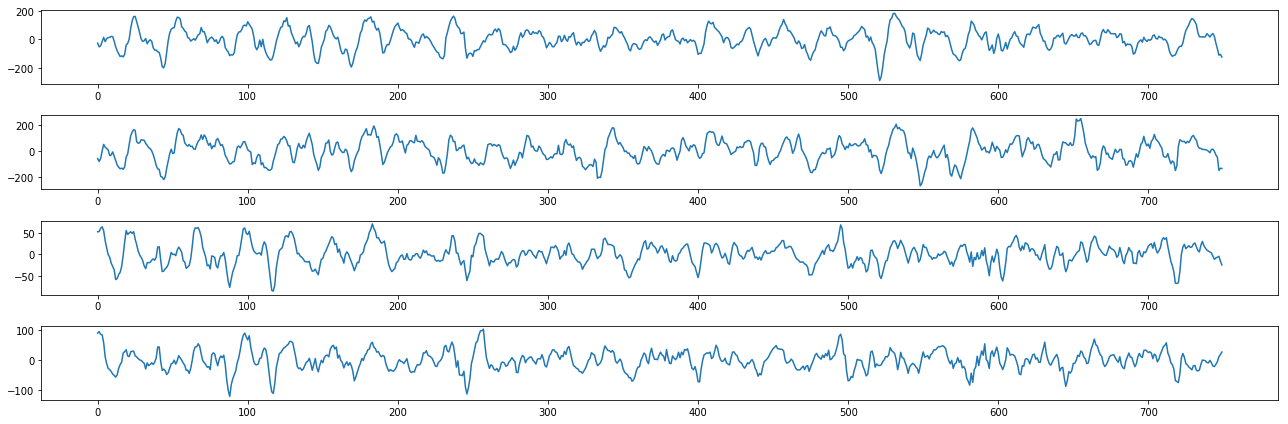

In [4]:
plt.figure(figsize=(18,6))
idx = np.random.choice(np.arange(eeg.shape[0]))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(eeg[idx,i])
plt.tight_layout()
plt.show()

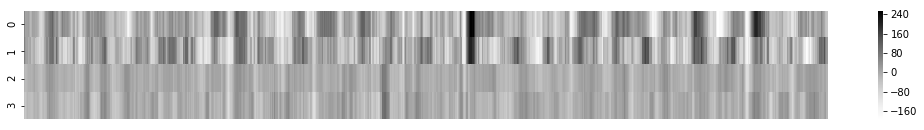

In [5]:
plt.figure(figsize=(18,2))
idx = np.random.choice(np.arange(eeg.shape[0]))
sns.heatmap(eeg[idx], cmap='Greys')
plt.xticks([])
plt.show()

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(4, 750, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 3), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded._keras_shape)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 3))(x)
decoded = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
print(decoded._keras_shape)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
i_t, i_v = train_test_split(np.arange(len(eeg)), shuffle=True, test_size=0.3)
x_t, x_v = eeg[i_t].reshape((len(i_t), 4, 750, 1)), eeg[i_v].reshape((len(i_v), 4, 750, 1))

In [ ]:
autoencoder.fit(x_t, x_t, epochs=10, batch_size=128, shuffle=True, validation_data=(x_v, x_v), verbose=2)

## TDA Description

In [6]:
def landscapes(dig, m_n=None, m_x=None, nb_landscapes=10, num_points=100, graph=False):

    # Automated construction of the landscapes
    # n_landscapes refers to the amount of landscapes to build
    # num_points refers to the amount of points to get as output
    # m_n, m_x refer to the extrema for discretization
    def build_landscapes(dig, nb_landscapes, num_points, m_n, m_x):

        # Prepares the discretization
        lcd = np.zeros((nb_landscapes, num_points))

        # Observe whether absolute or relative
        if m_n and m_x:
            stp = np.linspace(m_n, m_x, num=num_points)
        else:
            m_n, m_x = np.min(dig), np.max(dig)
            stp = np.linspace(m_n, m_x, num=num_points)

        # Use the triangular functions
        for idx, ele in enumerate(stp):
            val = []
            for pair in dig:
                b, d = pair[0], pair[1]
                if (d+b)/2.0 <= ele <= d: val.append(d - ele)
                elif  b <= ele <= (d+b)/2.0: val.append(ele - b)
            val.sort(reverse=True)
            val = np.asarray(val)
            for j in range(nb_landscapes):
                if (j < len(val)): lcd[j, idx] = val[j]

        return lcd

    # Computes the persistent landscapes for both diagrams
    dig = np.asarray([[ele[0], ele[1]] for ele in dig if ele[1] < np.inf])
    ldc = build_landscapes(dig, nb_landscapes, num_points, m_n, m_x)

    # Display landscapes if necessary
    if graph:
        plt.figure(figsize=(18,2))
        plt.title('Persistent Landscapes')
        for ele in ldc: plt.plot(ele)
        plt.show()

    return ldc        

In [7]:
def betti_curves(dig, m_n=None, m_x=None, num_points=100, graph=False):

    # Aims at barcode discretization
    def functionize(val, descriptor):

        # Temporary function
        def dirichlet(x):
            return 1 if (x > descriptor[0]) and (x < descriptor[1]) else 0

        # Vectorized function
        fun = np.vectorize(dirichlet)

        return fun(val)

    # Compute persistence
    res = np.zeros(num_points)
    dig = np.asarray([[ele[0], ele[1]] for ele in dig if ele[1] < np.inf])

    if m_n and m_x: 
        val = np.linspace(m_n, m_x, num=num_points)
    else:
        m_n, m_x = np.min(dig), np.max(dig)
        val = np.linspace(m_n, m_x, num=num_points)

    for ele in dig: res += functionize(val, ele)

    # Memory efficiency
    del dig, val

    if graph:
        plt.figure(figsize=(18,2))
        plt.plot(res, label='Sublevel Filtration - Betti Curve')
        plt.legend(loc='best')
        plt.show()

    return res

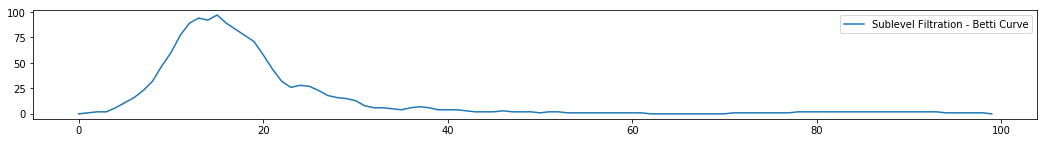

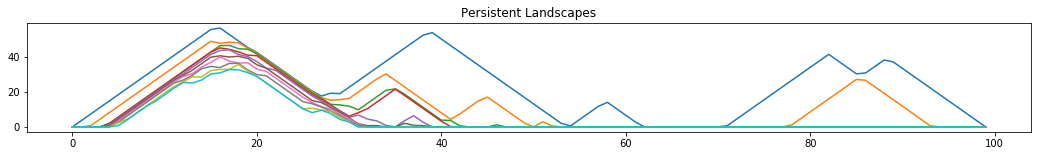

In [8]:
from ripser import Rips

rips = Rips(verbose=False, maxdim=1)
diagrams = rips.fit_transform(tmp.T)

_ = betti_curves(diagrams[1], graph=True)
_ = landscapes(diagrams[1], graph=True)